## 高维线性回归

使用线性函数$y = 0.05 + \sum_{i = 1}^p 0.01x_i +  \text{noise}$生成数据样本，噪音服从均值0和标准差为0.01的正态分布。

In [1]:
# 导入mxnet
import random
import mxnet as mx

# 设置随机种子
random.seed(2)
mx.random.seed(2)

from mxnet import gluon
from mxnet import ndarray as nd
from mxnet import autograd

## 生成数据集

In [2]:
# 训练数据数量
num_train = 20

# 测试数据数量
num_test = 100

# 输入数据特征维度
num_inputs = 200

# 实际权重
true_w = nd.ones((num_inputs, 1)) * 0.01

# 实际偏置
true_b = 0.05

In [3]:
# 生成数据
X = nd.random_normal(shape=(num_train + num_test, num_inputs))
y = nd.dot(X, true_w) + true_b

# 添加随机噪声
y += 0.01 * nd.random_normal(shape=y.shape)

# 训练数据和测试数据
X_train, X_test = X[:num_train, :], X[num_train:, :]
y_train, y_test = y[:num_train], y[num_train:]

In [4]:
# 批数据大小
batch_size = 1

# 通过yield进行数据读取
def data_iter(num_examples):
    # 产生样本的索引
    idx = list(range(num_examples))
    # 将索引随机打乱
    random.shuffle(idx)
    # 迭代一个epoch
    for i in range(0, num_examples, batch_size):
        # 依次取出样本的索引, 这种实现方式在num_examples/batch_size不能整除时也适用
        j = nd.array(idx[i:min((i + batch_size), num_examples)])
        # 根据提供的索引取元素
        yield nd.take(X, j), nd.take(y, j)

## 初始化模型参数

In [5]:
def init_params():
    # 随机初始化权重w
    w = nd.random_normal(shape=(num_inputs, 1))
    # 偏置b初始化为0
    b = nd.zeros((1,))
    # w, b放入list里
    params = [w, b]

    # 需要计算反向传播, 添加自动求导
    for param in params:
        param.attach_grad()
    return params

## $L_2$ 范数正则化

在训练时最小化函数为：$\text{loss} + \lambda \sum_{p \in \textrm{params}}\|p\|_2^2。$

In [6]:
# L2范数
def L2_penalty(w, b):
    return ((w**2).sum() + b ** 2) / 2

## 定义训练和测试

In [7]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt
import numpy as np


# 定义网络
def net(X, w, b):
    return nd.dot(X, w) + b

# 损失函数
def square_loss(yhat, y):
    return (yhat - y.reshape(yhat.shape)) ** 2 / 2

# 梯度下降
def sgd(params, lr, batch_size):
    for param in params:
        param[:] = param - lr * param.grad / batch_size

# 测试
def test(net, params, X, y):
    return square_loss(net(X, *params), y).mean().asscalar()

# 训练
def train(_lambda):
    # 定义训练的迭代周期
    epochs = 10
    # 定义学习率
    learning_rate = 0.005
    # 初始化参数
    w, b = params = init_params()
    # 训练损失
    train_loss = []
    # 测试损失
    test_loss = []
    for epoch in range(epochs):
        for data, label in data_iter(num_train):
            # 记录梯度
            with autograd.record():
                 # 计算预测值
                output = net(data, *params)
                # 计算loss
                loss = square_loss(output, label) + _lambda * L2_penalty(*params)
            # 反向传播
            loss.backward()
            # 更新梯度
            sgd(params, learning_rate, batch_size)
            # 训练损失
            train_loss.append(test(net, params, X_train, y_train))
            # 测试损失
            test_loss.append(test(net, params, X_test, y_test))
            
    # 绘制损失图像
    plt.plot(train_loss)
    plt.plot(test_loss)
    plt.legend(['train', 'test'])
    plt.show()
    return 'learned w[:10]:', w[:10].T, 'learned b:', b

# 观察过拟合

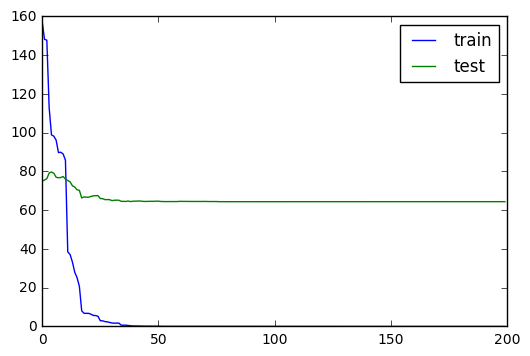

('learned w[:10]:', 
 [[ 1.04817176 -0.02568593  0.86764956  0.29322267  0.01006179 -0.56152576
    0.38436398 -0.30840367 -2.32450151  0.03733355]]
 <NDArray 1x10 @cpu(0)>, 'learned b:', 
 [ 0.79914856]
 <NDArray 1 @cpu(0)>)

In [8]:
train(0)

## 使用正则化

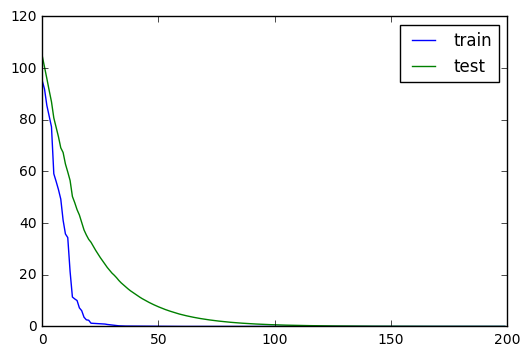

('learned w[:10]:', 
 [[ 0.00107633 -0.00052574  0.00450233 -0.00110545 -0.0068391  -0.00181657
   -0.00530632  0.00512845 -0.00742549 -0.00058495]]
 <NDArray 1x10 @cpu(0)>, 'learned b:', 
 [ 0.00449432]
 <NDArray 1 @cpu(0)>)

In [9]:
train(5)